In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)


In [3]:
def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp
classes = ['BH' ,'NS' ]
ns_n = 0 
bh_n = 0


In [4]:

def get_xy(data):
    y = data['class']
    s = data['significance']
    info = data[['src_n' , 'src_id']]
    x = data.drop(columns=[ 'class' ,'src_n' ,'src_id' , 'significance'])
    #display(x)
    y_train_int = class_to_int(y, classes)
    one_hot_y_train =  to_categorical(y_train_int)
    global ns_n 
    global bh_n
    ns_n = float(y.value_counts()['NS']) 
    bh_n =  float(y.value_counts()['BH'])    
    print(ns_n , bh_n)
    return x , one_hot_y_train

In [5]:
def fit_model(model , x_train , one_hot_y_train , verbose=0 , validation=0.2):
    global ns_n 
    global bh_n 
    class_weight = {0: (ns_n/bh_n),
                    1: 1}
    history = model.fit(x_train, one_hot_y_train, batch_size=64, epochs=120, validation_split=validation, class_weight=class_weight, verbose=verbose )
    return history

In [6]:
def res_score(model , x , y ):
    y_prob = model.predict(x)
    y_pred = np.zeros_like(y_prob)
    y_pred[np.arange(len(y_prob)), y_prob.argmax(1)] = 1
    cf = np.matrix(np.matmul(y.T , y_pred))
    total = cf.sum()
    row_sum = cf.sum(axis=0)
    acc = np.trace(cf) / total 
    col_sum = cf.sum(axis=1) 
    #print(cf)
    return cf , acc


#_ , score = res_score(model , x , one_hot_y_train)
#print(score)

In [16]:
from tqdm import tqdm
def mc_validation(model_func = '' , x = '' , split_data = '' , s=0.8 , model_name = '' , d_type = ''):
    from sklearn.model_selection import KFold
    kfold = KFold(8, True, 1)
    #k-fold cross-validation
    train_acc = []
    test_acc = []
    index = np.arange(0,len(x))
    split_no = int(len(x)*s)
    print('split_no' , split_no)
    for i in tqdm(range(32)):
        np.random.shuffle(index)
        data = x.copy()
        data = data.sample(frac=1)
        train , test = split_data(data)
        tf_data_train = tfdf.keras.pd_dataframe_to_tf_dataset(train,label="class")
        tf_data_test = tfdf.keras.pd_dataframe_to_tf_dataset(test,label="class")
        model = model_func()
        #with sys_pipes():
        model.fit(tf_data_train)
        model.compile(metrics=['accuracy'])

        evaluation = model.evaluate(tf_data_train, return_dict=True)
        _ ,  train_acc_temp = evaluation.items()
        train_acc_temp = train_acc_temp[1]
        evaluation = model.evaluate(tf_data_test, return_dict=True)
        _ ,  test_acc_temp = evaluation.items()
        test_acc_temp = test_acc_temp[1]
        #_,train_acc_temp = res_score(model , xtr , ytr)
        #_,test_acc_temp = res_score(model , xtst , ytst)
        train_acc.append(train_acc_temp)
        test_acc.append(test_acc_temp)
        print('-----------------------------------')
        print('training_acc :' , train_acc_temp)
        print('test_acc :' , test_acc_temp)
    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    acc.insert(1 , 'data_processing' , [d_type]*len(acc))
    return acc


In [17]:
def src_split(data_sent , s = (5 , 8) ):
    data = data_sent.copy().reset_index(drop=True)
    data_bh =  data[data['class']=='BH'].sample(frac=1)
    data_ns =  data[data['class']=='NS'].sample(frac=1)
    n_bh  , n_ns = s 
    
    src_bh =  np.unique(data_bh['src_id'])
    np.random.shuffle(src_bh)
    src_ns = np.unique(data_ns['src_id'])
    np.random.shuffle(src_ns)
    s_bh = len(src_bh) - n_bh 
    s_ns = len(src_ns) - n_ns 
    print(s_bh , s_ns)
    src_bh_train = src_bh[:s_bh]
    src_bh_test = src_bh[s_bh:]
    src_ns_train = src_ns[:s_ns]
    src_ns_test = src_ns[s_ns:]
    print(src_bh_test)
    train_bh = data_bh[data_bh['src_id'].isin(src_bh_train)].reset_index(drop=True)
    test_bh = data_bh[data_bh['src_id'].isin(src_bh_test)].reset_index(drop=True)

    train_ns = data_ns[data_ns['src_id'].isin(src_ns_train)].reset_index(drop=True)
    test_ns = data_ns[data_ns['src_id'].isin(src_ns_test)].reset_index(drop=True)

    train = pd.concat([train_bh , train_ns]).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)

    test = pd.concat([test_bh , test_ns]).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    return train , test 

def obs_split(data_sent , s = 0.8):
    data = data_sent.copy()
    data = data.sample(frac=1)
    split_no = int(len(data)*s)
    train = data[:split_no]
    test = data[split_no:]
    return train, test

In [18]:
data = pd.read_csv('processed_data/train_norm' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
#display(data.describe())
x_norm , y_norm = get_xy(data)

data = pd.read_csv('processed_data/train_std' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
#display(data.describe())
x_std , y_std = get_xy(data) 

data = pd.read_csv('processed_data/train_og' , index_col=0).reset_index(drop=True)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
#display(data.describe())
x_og , y_og = get_xy(data)

302.0 158.0
302.0 158.0
302.0 158.0


# Keras Random Forest Classifier

In [19]:
import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes
gen_model_rf =  tfdf.keras.RandomForestModel

In [20]:
acc_norm_rf = mc_validation(gen_model_rf , data  , src_split ,model_name = 'RF' , d_type='Normalized')
acc_std_rf = mc_validation(gen_model_rf , data , src_split, model_name = 'RF' , d_type = 'Standardized')
acc_og_rf = mc_validation(gen_model_rf , data  , src_split ,  model_name = 'RF' , d_type = 'None')

/home/kumaran/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


split_no 368


  0%|          | 0/32 [00:00<?, ?it/s]

22 40
['BH0008' 'BH0031' 'BH0018' 'BH0016' 'BH0003']


  0%|          | 0/32 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [101]:
acc_data_rf = pd.concat([acc_norm_rf , acc_std_rf ,  acc_og_rf]).reset_index(drop=True)
print(acc_data_rf)
acc_data_rf.to_csv('result/acc_result_rf')


    model data_processing   acc_type  accuracy
0      RF      Normalized  Train_acc  1.000000
1      RF      Normalized  Train_acc  1.000000
2      RF      Normalized  Train_acc  1.000000
3      RF      Normalized  Train_acc  1.000000
4      RF      Normalized  Train_acc  1.000000
..    ...             ...        ...       ...
187    RF            None   Test_acc  0.913043
188    RF            None   Test_acc  0.956522
189    RF            None   Test_acc  0.923913
190    RF            None   Test_acc  0.956522
191    RF            None   Test_acc  0.945652

[192 rows x 4 columns]


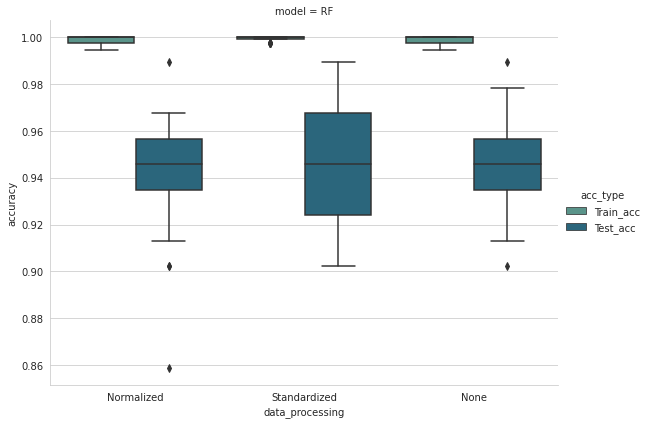

In [112]:
import seaborn as sns 
acc_prev =  pd.read_csv('result/accuracy_result').reset_index(drop=True)
acc_prev_rf =  pd.read_csv('result/acc_result_rf').reset_index(drop=True)
acc_all = pd.concat([ acc_prev_rf]).reset_index(drop=True)
sns.set_style('whitegrid')
sns.catplot(data = acc_all , y='accuracy' , x = 'data_processing' ,
            hue= 'acc_type' , col = 'model' , kind='box' ,
            palette = 'crest' , height=6 , aspect=8/6
            )
plt.savefig('result/model_var_rf.jpg')
plt.show()

In [105]:
with open("plot.html", "w") as f:
    f.write(tfdf.model_plotter.plot_model(
        model ,
        tree_idx = 250 ,
        max_depth = 20
        ))